__Feature Selection__ is performed using combination of Gabor Filter and Laplacian of Guassian.

**Gabor Filter** - Captures texture information by responding to edges, bars, or wave-like structures at specific orientations and scales.

**LoG** - Enhances edges and sharp transitions in the image by highlighting regions of rapid intensity change.



In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gabor_filter(image, ksize=21, sigma=5, theta=0, lamda=1*np.pi, gamma=0.5, psi=0):
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, psi, ktype=cv2.CV_32F)
    filtered_image = cv2.filter2D(image, -1, kernel)
    return filtered_image

In [8]:
def laplacian_of_gaussian(image, sigma=0.5):
    blur = cv2.GaussianBlur(image, (0, 0), sigma)
    # Change output depth to CV_32F instead of CV_64F
    laplacian = cv2.Laplacian(blur, cv2.CV_32F)
    return laplacian


In [9]:
def apply_hybrid_gabor_log(image):
    # If the image has more than one channel, convert it to grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert image to float32 if it's not already, and normalize to [0, 1]
    if image.dtype != np.float32:
        image = np.float32(image) / 255.0

    theta_values = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Different orientations for Gabor
    gabor_features = np.zeros_like(image, dtype=float)

    for theta in theta_values:
        gabor_features += gabor_filter(image, theta=theta)

    # Normalize Gabor features to range [0, 1]
    gabor_features = cv2.normalize(gabor_features, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # LoG Features
    log_features = laplacian_of_gaussian(image)

    # Combine features using a weighted sum
    combined_features = cv2.addWeighted(gabor_features, 0.5, log_features, 0.5, 0)
    return combined_features


In [10]:
def load_npy_files(image_path, label_path):
    images = np.load(image_path)
    labels = np.load(label_path)
    return images, labels

In [11]:
def apply_hybrid_filters_to_batch(images):
    # Assuming images are stored as numpy arrays
    processed_images = []
    for image in images:
        processed_image = apply_hybrid_gabor_log(image)
        processed_images.append(processed_image)
    return np.array(processed_images)

In [12]:
import numpy as np
import os

def process_all_batches(data_folder):
    all_processed_images = []
    all_labels = []

    # Total number of batches - adjust according to your files
    num_batches = 180  # Update if needed

    for i in range(num_batches + 1):  # +1 because range is exclusive at the end
        image_path = os.path.join(data_folder, f'images_batch_{i}.npy')
        label_path = os.path.join(data_folder, f'labels_batch_{i}.npy')

        # Load batches
        images = np.load(image_path)
        labels = np.load(label_path)

        # Process each image in the batch
        processed_images = apply_hybrid_filters_to_batch(images)

        # Append processed images and labels to lists
        all_processed_images.append(processed_images)
        all_labels.append(labels)

    return all_processed_images, all_labels

# Path to the folder containing your npy files
data_folder = '/Users/issackondreddy/Desktop/Programming/ML Project/Lung Cancer Detection/data/processed'
processed_images, processed_labels = process_all_batches(data_folder)


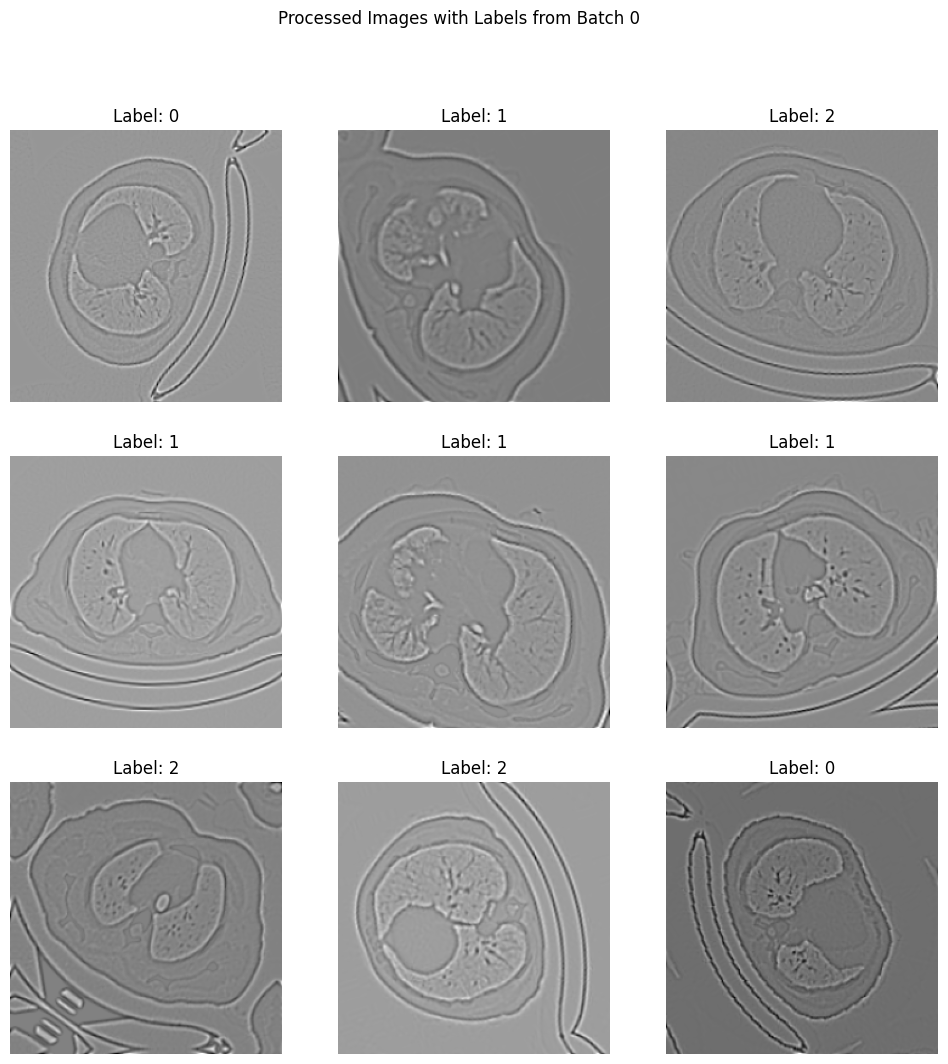

In [16]:
import matplotlib.pyplot as plt

# Assuming processed_images and processed_labels are lists of batches
first_batch_images = processed_images[0]
first_batch_labels = processed_labels[0]

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(first_batch_images[i], cmap='gray')
    plt.title(f"Label: {first_batch_labels[i]}")
    plt.axis('off')
plt.suptitle("Processed Images with Labels from Batch 0")
plt.show()
